# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
# import required libraries
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import warnings

# ignore deprecation warnings
warnings.filterwarnings('ignore')
% matplotlib inline

# reading the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Part 1. Data Exploration

##### Checking shape of portfolio, profile and transcript datasets

In [2]:
# Shape of portfolio Dataframe
print("Portfolio Size = {}".format(portfolio.shape))
portfolio.head()

Portfolio Size = (10, 6)


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
# Shape of profile Dataframe
print("Profile Size = {}".format(profile.shape))
profile.head()

Profile Size = (17000, 5)


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
# Shape of transcript Dataframe
print("Transcript Size = {}".format(transcript.shape))
transcript.head()

Transcript Size = (306534, 4)


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


### Exploration For Each Dataframe

#### Portfolio Dataframe

In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [6]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


#### Function for plotting a Bar Chart

In [7]:
def horizontal_bar_plot(df, colName, pltTitle, pltfigsize=[5,5], bInvertYAxis=True, fntSize=12, fntWeight='bold'):
    """
    Creates a horizontal bar plot with counts of categories
    
    Parameters
    ----------
    df: The dataframe with categories.
    
    colName: The name of the column containing the categories.
    
    pltTitle: The plot title.
    
    pltfigsize: The figure size of the plot (default is [5,5]).
    
    bInvertYAxis: A flag to indicating whether to invert the Y-Axis or not.
    
    fntSize: The font size of text (default to 12 point font size)
    
    fntWeight: The weight of font (default to 'bold', it could be 'italic')
    
    Returns
    -------
    None
    """
    plt.figure(figsize=pltfigsize)
    fig, ax = plt.subplots()    
    y_counts = df[colName].value_counts()
    if bInvertYAxis == True:
        y_counts.plot(kind='barh').invert_yaxis()
    else:
         y_counts.plot(kind='barh')   
    for i, v in enumerate(y_counts):
        ax.text(v, i, str(v), color='black', fontsize=fntSize, fontweight=fntWeight)
        plt.title(pltTitle)

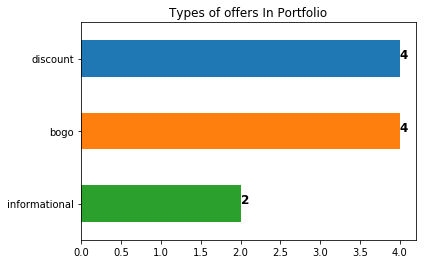

In [8]:
horizontal_bar_plot(portfolio, 'offer_type', "Types of offers In Portfolio")

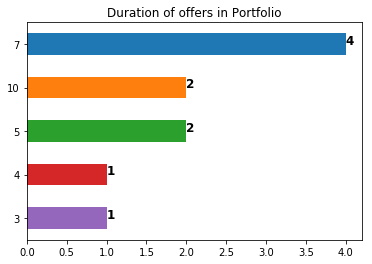

In [9]:
horizontal_bar_plot(portfolio, 'duration', "Duration of offers in Portfolio")

In [10]:
def check_nan(dataframe):
    nan_columns = dataframe.columns[dataframe.isna().any()].tolist()
    total = len(dataframe)
    print("Total : {}".format(total))
    for column in nan_columns:
        count = dataframe[column].isna().sum()
        print("{} : {}, remaining : {}".format(column, count, total - count))

In [11]:
check_nan(portfolio)

Total : 10


#### Profile Dataframe

In [12]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [13]:
profile.describe(include="all")

,age,became_member_on,gender,id,income
count,17000.000000,1.700000e+04,14825,17000,14825.000000
unique,NaN,NaN,3,17000,NaN
top,NaN,NaN,M,0b8503be108149b58bdd5f1827612fdc,NaN
freq,NaN,NaN,8484,1,NaN
mean,62.531412,2.016703e+07,NaN,NaN,65404.991568
std,26.738580,1.167750e+04,NaN,NaN,21598.299410
min,18.000000,2.013073e+07,NaN,NaN,30000.000000
25%,45.000000,2.016053e+07,NaN,NaN,49000.000000
50%,58.000000,2.017080e+07,NaN,NaN,64000.000000
75%,73.000000,2.017123e+07,NaN,NaN,80000.000000


In [14]:
# checking for null values
check_nan(profile)

Total : 17000
gender : 2175, remaining : 14825
income : 2175, remaining : 14825


In [15]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

__Note:__ On analyzing the data, I have founded that gender and income values are missing for age 118. Let's see further analysis on this aspect

In [16]:
profile[profile['age']== 118].age.count()

2175

In [17]:
profile[profile['age']== 118].drop(['became_member_on' ,'id'], axis=1)

,age,gender,income
0,118,None,NaN
2,118,None,NaN
4,118,None,NaN
6,118,None,NaN
7,118,None,NaN
9,118,None,NaN
10,118,None,NaN
11,118,None,NaN
17,118,None,NaN
23,118,None,NaN


As analyzed the values of gender and income are missing for age 118

##### Analysing Age Values in Profile Dataframe

In [18]:
#check for different age values
profile.age.value_counts()

118    2175
58      408
53      372
51      363
54      359
59      359
57      353
52      351
55      350
56      342
63      338
60      333
49      321
62      318
67      317
64      311
61      309
48      288
50      284
66      284
65      280
68      259
70      252
69      242
47      232
45      231
71      230
42      227
43      215
46      212
       ... 
22      131
30      131
29      129
23      126
81      118
35      118
79      117
80      116
31      113
82      105
83      102
84       83
18       70
85       70
87       66
88       64
86       54
89       53
90       52
91       47
92       40
94       33
93       29
95       22
97       13
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64

__Let's implement a box plot to analyze age further__

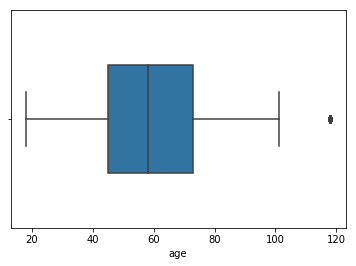

In [19]:
sns.boxplot(profile['age'], width=0.5);

From the boxplot it can be analyzed that people with age greater than 80 are not major users of mobile app and don't drink much beverages so people with age more than 80 can be considerd as outliers

##### Analysing Gender Values in Profile Dataframe

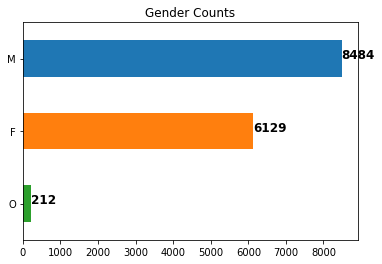

In [20]:
horizontal_bar_plot(profile, 'gender', "Gender Counts")

__Plotting a Pie Chart for Gender Counts in Profile Dataframe__

In [21]:
def exploded_pie_plot(df, colName, pltTitle, pltColors=[], pltLabels=[], pltExplode=(), pltFigSize=[5, 5]):
    """
    Creates an exploded pie plot with percentages of each categories for the column provided.
    
    Parameters
    ----------
    df: The dataframe with categories.
    
    colName: The name of the column containing the categories.
    
    pltTitle: The plot title.
    
    pltColors: The array of colors to use.
    
    pltLabels: The array of plot labels to use for each of the categories.
    
    pltExplode: The proportions to pass in for exploding the slices (e.g. 0.1, 0, 0 will explode the first category out by 10%)
    
    pltFigSize: The figure size of the plot (default is [5,5])
    
    Returns
    -------
    None
    """
    plt.figure(figsize=[5, 5])
    pltValues = df[colName].value_counts()
    colors = pltColors
    labels = pltLabels
    explode = pltExplode # if (0.1, 0, 0) then explode 1st slice by 10% and dont explode 2nd and 3rd slizes
    plt.pie(pltValues, colors=pltColors, labels=pltLabels, explode=pltExplode, autopct='%1.2f%%', counterclock=False, shadow=True)
    plt.title(pltTitle)

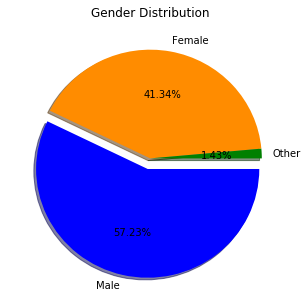

In [22]:
exploded_pie_plot(profile, 'gender', 'Gender Distribution', ['blue', 'darkorange', 'green'], ['Male', 'Female', 'Other'], (0.1, 0, 0))

#### Transcript Dataframe

In [23]:
transcript.head(10)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [24]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [25]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [26]:
transcript.value.value_counts()

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}                  14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}                  14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}                  14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}                  14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}                  14374
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}                  14305
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}                  11848
{'offer id': '3f207df678b143eea3cee63160fa8bed'}                  11761
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}                  11750
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}                  10331
{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}      5317
{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}      5156
{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}      4354
{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}   

I have analyzed that there are 4 possible values 'offer id','offer_id','reward' and 'amount' and out of these 'offer id' and 'offer_id' are to considerd same

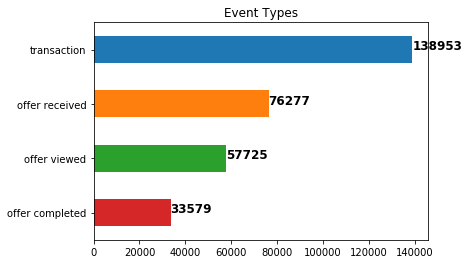

In [27]:
horizontal_bar_plot(transcript, 'event', "Event Types")

__Let's see the major points we can conclude from data exploration__

- The gender and income values are missing for age 118
- People of age more than 80 are not major users of mobile app so act as outliers
- In terms of gender distribution the no. of males are more than no. of females
- Also, all the offers received are not necessarily completed and some are not even viewed

Here, I am done with the data exploration part and next step will be data cleaning and pre-processing.

### Part 2. Data Cleaning and Pre-processing

##### Cleaning Portfolio

__I will rename the columns and the reasons are mentioned below:__
- For better understanding
- Easier to merge dataframes later

In [28]:
def rename_cols(df, new_cols_name):
    """
    Parameters
    ----------
    df: input dataframe for renaming columns
    new_cols_name: define new column name for each column
    
    Returns
    -------
    df: output data frame with renamed column names
       
    """

    df= df.rename(columns = new_cols_name)
    return df

In [29]:
#renaming the columns of portfolio
new_cols_name = {'difficulty':'offer_difficulty' , 'id':'offer_id', 'duration':'offer_duration', 'reward': 'offer_reward'}
cleaned_portfolio = rename_cols(portfolio, new_cols_name )

In [30]:
#checking out cleaned portfolio
cleaned_portfolio.head()

,channels,offer_difficulty,offer_duration,offer_id,offer_type,offer_reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [31]:
cleaned_portfolio.columns

Index(['channels', 'offer_difficulty', 'offer_duration', 'offer_id',
       'offer_type', 'offer_reward'],
      dtype='object')

Now I have cleaned the portfolio dataframe, it's more understandable and easy to use

##### Cleaning Profile

__List of tasks to perform for cleaning profile dataframe:__
1. Renaming some columns for better understanding and to make it easier to merge dataframes later
2. Replace missing age with mean age value
3. Replace missing income with mean income value
4. Replace missing gender with mode value
5. People with age more than 80 act as outliers so removing them
6. Classifying age into different age groups for better understanding

In [32]:
#rename columns
cols_profile = {'id':'customer_id' , 'income':'customer_income'}
cleaned_profile = rename_cols(profile, cols_profile )

In [33]:
cleaned_profile.head()

,age,became_member_on,gender,customer_id,customer_income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [34]:
def cleaning_profile(df):
    """
    Clean the profile data frame as per tasks 2-4
        
    Parameters
    ----------   
    df: data frame
    
    Returns
    -------
    df: output data frame as per tasks
    """
    
    
    #deal with null values
    #replace 118 age values with NaN so to replace them easily with mean age
    df.replace(118, np.nan , inplace=True)
    #replace NaN age values with mean age
    df['age'] = df['age'].fillna(df['age'].mean())
    #replace missing income values with mean income
    df['customer_income'] = df['customer_income'].fillna(df['customer_income'].mean())
    #replace missing gender values with mode i.e. most frequent gender
    mode = df['gender'].mode()[0]
    df['gender'] = df['gender'].fillna(mode)
    
    #remove outliers
    df = df[df['age'] <= 80]
    df['age'] = df['age'].astype(int)
    
    #add Age_group column
    df.loc[(df.age < 20) , 'Age_group'] = 'Under 20'
    df.loc[(df.age >= 20) & (df.age <= 45) , 'Age_group'] = '20-45'
    df.loc[(df.age >= 46) & (df.age <= 60) , 'Age_group'] = '46-60'
    df.loc[(df.age >= 61) , 'Age_group'] = '61-80'
    df.drop('age',axis=1,inplace=True)
    return df

In [35]:
cleaned_profile = cleaning_profile(cleaned_profile)

In [36]:
cleaned_profile.head()

,became_member_on,gender,customer_id,customer_income,Age_group
0,20170212,M,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,46-60
1,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.000000,46-60
2,20180712,M,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,46-60
3,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,61-80
4,20170804,M,a03223e636434f42ac4c3df47e8bac43,65404.991568,46-60


In [37]:
#check for missing values 
cleaned_profile.isnull().sum()

became_member_on    0
gender              0
customer_id         0
customer_income     0
Age_group           0
dtype: int64

In [38]:
cleaned_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16014 entries, 0 to 16999
Data columns (total 5 columns):
became_member_on    16014 non-null int64
gender              16014 non-null object
customer_id         16014 non-null object
customer_income     16014 non-null float64
Age_group           16014 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 750.7+ KB


In [39]:
cleaned_profile.shape

(16014, 5)

In [40]:
check_nan(cleaned_profile)

Total : 16014


I am done with cleaning the profile dataframe, now dataframe has no null values and I have also eliminated outliers

##### Cleaning Transcript

__In the transcript dataframe, I will perform two major tasks for cleaning the dataframe and are as follows:__
1. Renaming some columns for better understanding and to make it easier to merge dataframes later
2. Expand the dictionary to columns i.e. Expand the keys of the values column into new columns


In [41]:
def cleaning_transcript(df):
    """
    Cleaning the transcript data frame as per task 2.
    
    Parameters
    ----------   
    df: data frame
    
    Returns
    -------
    df: output data frame as per task
    
    New column names given for expanded keys
    -------
    money_gained : money gained from "offer completed"
    money_spent : money spent in "transaction"
    offer_id 
    """
    
    #expand the dictionary to coulmns 
    df['offer_id'] = df['value'].apply(lambda x: x.get('offer_id'))
    df['offer id'] = df['value'].apply(lambda x: x.get('offer id'))
    df['money_gained'] = df['value'].apply(lambda x: x.get('reward'))
    df['money_spent'] = df['value'].apply(lambda x: x.get('amount'))
    
    #move 'offer id' values into 'offer_id'
    df['offer_id'] = df.apply(lambda x : x['offer id'] if x['offer_id'] == None else x['offer_id'], axis=1)
    #drop 'offer id' column 
    df.drop(['offer id' , 'value'] , axis=1, inplace=True)
    #replace nan
    df.fillna(0 , inplace=True)
    
    return df

In [42]:
#rename columns
transcript_cols = {'person':'customer_id'}
cleaned_transcript = rename_cols(transcript, transcript_cols)

In [43]:
cleaned_transcript.columns

Index(['event', 'customer_id', 'time', 'value'], dtype='object')

In [44]:
cleaned_transcript = cleaning_transcript(cleaned_transcript)

In [45]:
cleaned_transcript.head()

,event,customer_id,time,offer_id,money_gained,money_spent
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0


In [46]:
cleaned_transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 6 columns):
event           306534 non-null object
customer_id     306534 non-null object
time            306534 non-null int64
offer_id        306534 non-null object
money_gained    306534 non-null float64
money_spent     306534 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 14.0+ MB


I have cleaned the transcript dataframe and now the keys of value column have been expanded into new columns and also moved 'offer id' values to 'offer_id' and renamed columns for easier understanding of data

#### Merging the three Dataframes

In [47]:
def merge_data(portfolio,profile,transcript):
    """
    Merge cleaned data frames for EDA
       
    Parameters
    ---------- 
    portfolio : cleaned portfolio data frame
    profile : cleaned profile data frame
    transcript : cleaned transcript data frame
      
    Returns
    -------
    merged_df: merged data frame
    
    """
    
    merged_df = pd.merge(portfolio, transcript, on='offer_id')
    merged_df = pd.merge(merged_df, profile, on='customer_id')
    
    return merged_df

In [48]:
merged_df = merge_data(cleaned_portfolio, cleaned_profile, cleaned_transcript)

In [49]:
merged_df.head()

,channels,offer_difficulty,offer_duration,offer_id,offer_type,offer_reward,event,customer_id,time,money_gained,money_spent,became_member_on,gender,customer_income,Age_group
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,0.0,0.0,20170909,M,100000.0,61-80
1,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,102,0.0,0.0,20170909,M,100000.0,61-80
2,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer received,4b0da7e80e5945209a1fdddfe813dbe0,504,0.0,0.0,20170909,M,100000.0,61-80
3,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,510,0.0,0.0,20170909,M,100000.0,61-80
4,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer completed,4b0da7e80e5945209a1fdddfe813dbe0,510,10.0,0.0,20170909,M,100000.0,61-80


In [50]:
merged_df.shape

(157503, 15)

In [51]:
merged_df

,channels,offer_difficulty,offer_duration,offer_id,offer_type,offer_reward,event,customer_id,time,money_gained,money_spent,became_member_on,gender,customer_income,Age_group
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,0.0,0.0,20170909,M,100000.000000,61-80
1,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,102,0.0,0.0,20170909,M,100000.000000,61-80
2,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer received,4b0da7e80e5945209a1fdddfe813dbe0,504,0.0,0.0,20170909,M,100000.000000,61-80
3,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,510,0.0,0.0,20170909,M,100000.000000,61-80
4,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer completed,4b0da7e80e5945209a1fdddfe813dbe0,510,10.0,0.0,20170909,M,100000.000000,61-80
5,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,offer received,4b0da7e80e5945209a1fdddfe813dbe0,408,0.0,0.0,20170909,M,100000.000000,61-80
6,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,468,0.0,0.0,20170909,M,100000.000000,61-80
7,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,offer received,4b0da7e80e5945209a1fdddfe813dbe0,168,0.0,0.0,20170909,M,100000.000000,61-80
8,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,174,0.0,0.0,20170909,M,100000.000000,61-80
9,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,offer completed,4b0da7e80e5945209a1fdddfe813dbe0,180,5.0,0.0,20170909,M,100000.000000,61-80


By now I am done with cleaning and pre-processing of data. Now we can use our data for using in a Machine Learning Model and continue with the next part which is Exploratory Data Analysis(EDA).

### Part 3. Exploratory Data Analysis (EDA)

Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.It is a good practice to understand the data first and try to gather as many insights from it. EDA is all about making sense of data in hand,before getting them dirty with it.

#### Most used offer by the customer using the app

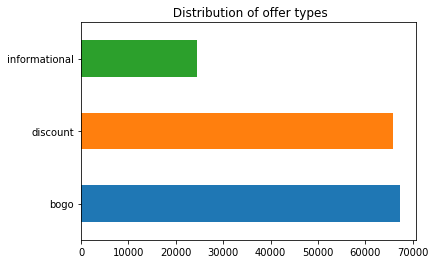

In [52]:
merged_df['offer_type'].value_counts().plot.barh(title=' Distribution of offer types')

We can observe that discount and bogo have nearly the same distribution

#### Income of customers using the app

In [53]:
merged_df['customer_income'].mean()

65924.491099765321

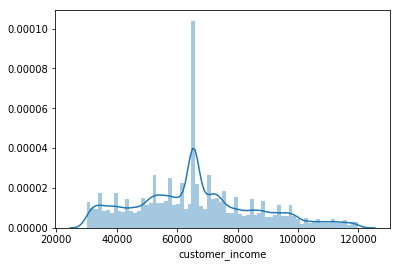

In [54]:
sns.distplot(merged_df['customer_income'], bins=70, hist_kws={'alpha': 0.4});

#### Age Distribution of customer

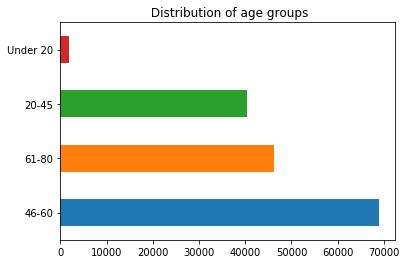

In [55]:
merged_df['Age_group'].value_counts().plot.barh(title=' Distribution of age groups')

We can observe a very interesting thing here, the one with age-group 46-60 are the most in number for using the starbucks mobile app and one with 61-80 are at number second. Generally we tend to think that 20-45 will be the most frequent users but that's not the case

#### Actions to offer that customers received

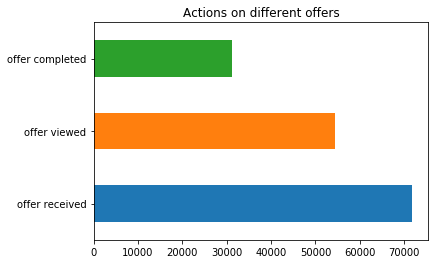

In [56]:
merged_df['event'].value_counts().plot.barh(title='Actions on different offers')

The above plot implies not all offers received are completed i.e. many times people tend to ignore the offer and sometimes not even view it.

#### Gender based distribution

In [57]:
plot_gender = merged_df[merged_df['gender'] != 'O']

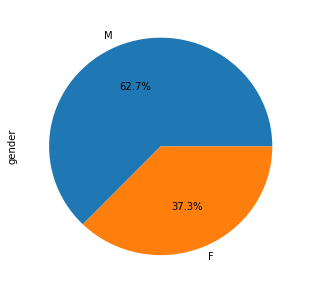

In [58]:
plot_gender.gender.value_counts().plot(kind='pie' , figsize=(5, 5), autopct='%1.1f%%')

The percentage of males is more than percentage of females

#### Age groups of Males and Females

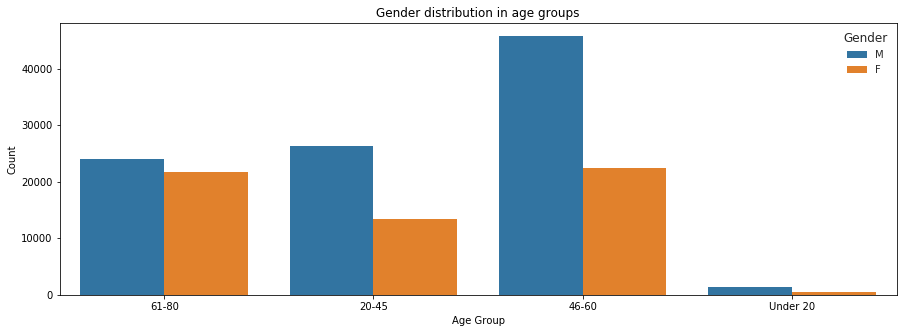

In [59]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "Age_group", hue= "gender", data=plot_gender)
sns.set(style="darkgrid")
plt.title('Gender distribution in age groups')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Gender')

The male customers are more than the female ones in each age group



#### Gender Distribution in each offer type

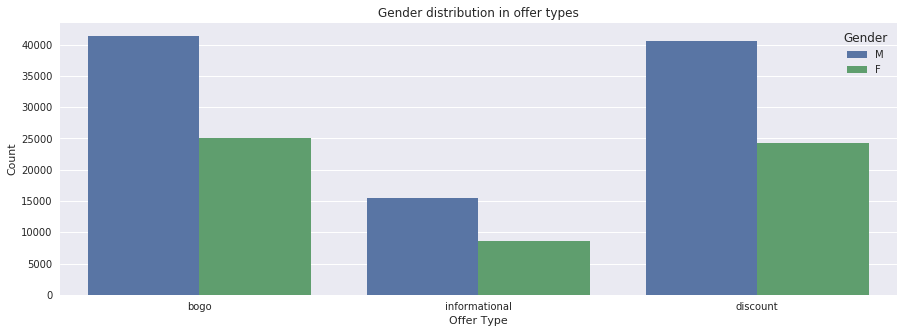

In [60]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "offer_type", hue= "gender", data=plot_gender)
sns.set(style="darkgrid")
plt.title('Gender distribution in offer types')
plt.ylabel('Count')
plt.xlabel('Offer Type')
plt.legend(title='Gender')

#### Action to offers by Male And Females

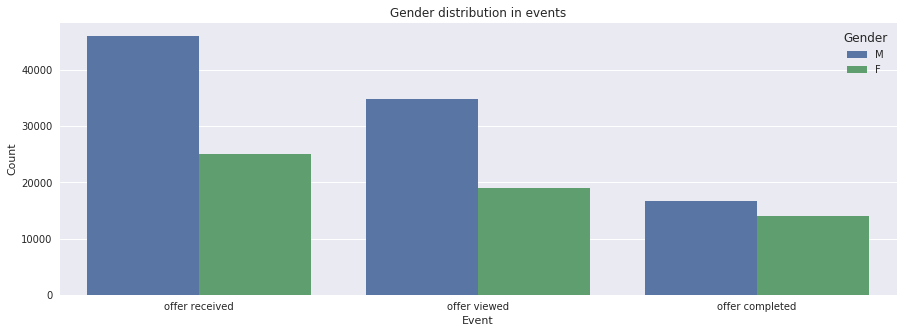

In [61]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "gender", data=plot_gender)
sns.set(style="darkgrid")
plt.title('Gender distribution in events')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Gender')

#### Actions to offer in each offer type

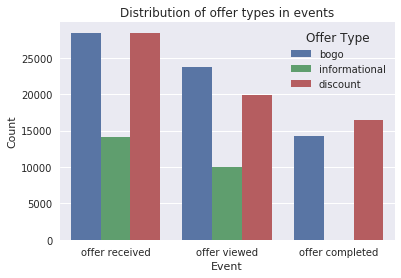

In [62]:
sns.countplot(x= "event", hue= "offer_type", data=plot_gender)
sns.set(style="darkgrid")
plt.title('Distribution of offer types in events')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Offer Type')

#### Actions to the offers in each age group

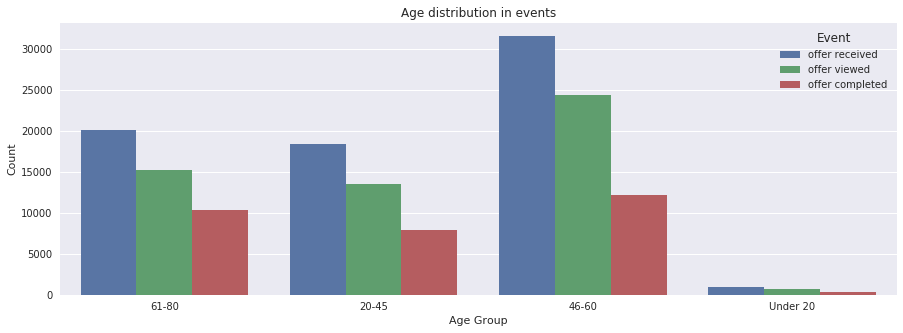

In [63]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "Age_group", hue= "event", data=plot_gender)
sns.set(style="darkgrid")
plt.title('Age distribution in events')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Event')

The males represent 62.7% of the data and use the Starbucks app more than the females. Specifically, both males & females in the age group 46-60 use app the most. Also, we can look more to the figures & information in Exploratory Data Analysis to best determine which kind of offers to send to the customers.

### Part 4. Building A Machine Learning Model

Before building a model, we will have to clean it a bit further. We need to do the following tasks

1. Convert categorical features into numeric format
2. Encode the 'event' data to numerical values
    - offer received - 1
    - offer viewed - 2
    - offer completed - 3
3. Encode offer_id and customer_id
4. Drop column 'became_member_on' and add separate columns for month and year
5. Scale and normalize numerical data

In [64]:
merged_df.head()

,channels,offer_difficulty,offer_duration,offer_id,offer_type,offer_reward,event,customer_id,time,money_gained,money_spent,became_member_on,gender,customer_income,Age_group
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,0.0,0.0,20170909,M,100000.0,61-80
1,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,102,0.0,0.0,20170909,M,100000.0,61-80
2,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer received,4b0da7e80e5945209a1fdddfe813dbe0,504,0.0,0.0,20170909,M,100000.0,61-80
3,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,510,0.0,0.0,20170909,M,100000.0,61-80
4,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer completed,4b0da7e80e5945209a1fdddfe813dbe0,510,10.0,0.0,20170909,M,100000.0,61-80


In [65]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157503 entries, 0 to 157502
Data columns (total 15 columns):
channels            157503 non-null object
offer_difficulty    157503 non-null int64
offer_duration      157503 non-null int64
offer_id            157503 non-null object
offer_type          157503 non-null object
offer_reward        157503 non-null int64
event               157503 non-null object
customer_id         157503 non-null object
time                157503 non-null int64
money_gained        157503 non-null float64
money_spent         157503 non-null float64
became_member_on    157503 non-null int64
gender              157503 non-null object
customer_income     157503 non-null float64
Age_group           157503 non-null object
dtypes: float64(3), int64(5), object(7)
memory usage: 19.2+ MB


In [66]:
def cleaning_final_data(df):
    """
    Clean merged data frame for the final data as per tasks 1-5.
    
    Parameters
    ----------
    df: input data frame
    
    Returns
    -------
    df: cleaned data frame as per tasks
       
    """
    #process categorical variables
    categorical = ['offer_type', 'gender', 'Age_group']
    df = pd.get_dummies(df, columns = categorical)
    #process channels column 
    df = df.drop('channels', 1).join(df.channels.str.join('|').str.get_dummies())
    
    #process became_member_on column
    #change datatype of became_member_on 
    df['became_member_on'] = df['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
    #add new columns for month & year
    df['month_member'] = df['became_member_on'].apply(lambda x: x.day)
    df['year_member'] = df['became_member_on'].apply(lambda x: x.year)
    #drop became_member_on column
    df.drop('became_member_on',axis=1, inplace=True)    
    
    #process offer_id column
    offerids = df['offer_id'].unique().tolist()
    o_mapping = dict( zip(offerids,range(len(offerids))) )
    df.replace({'offer_id': o_mapping},inplace=True)
    
    #process customer_id column
    cusids = df['customer_id'].unique().tolist()
    c_mapping = dict( zip(cusids,range(len(cusids))) )
    df.replace({'customer_id': c_mapping},inplace=True)
    
    #process numerical variables
    #initialize a MinMaxScaler, then apply it to the features
    scaler = MinMaxScaler() # default=(0, 1)
    numerical = ['customer_income', 'offer_difficulty', 'offer_duration', 'offer_reward', 'time', 'money_gained', 'money_spent']
    df[numerical] = scaler.fit_transform(df[numerical])
    
    #encode 'event' data to numerical values according to task 2
    df['event'] = df['event'].map({'offer received':1, 'offer viewed':2, 'offer completed':3})
    
    return df

In [67]:
cleaned_data = cleaning_final_data(merged_df)

In [68]:
cleaned_data.head()

,offer_difficulty,offer_duration,offer_id,offer_reward,event,customer_id,time,money_gained,money_spent,customer_income,...,Age_group_20-45,Age_group_46-60,Age_group_61-80,Age_group_Under 20,email,mobile,social,web,month_member,year_member
0,0.5,0.571429,0,1.0,1,0,0.000000,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
1,0.5,0.571429,0,1.0,2,0,0.142857,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
2,0.5,0.571429,0,1.0,1,0,0.705882,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
3,0.5,0.571429,0,1.0,2,0,0.714286,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
4,0.5,0.571429,0,1.0,3,0,0.714286,1.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017


In [69]:
cleaned_data.shape

(157503, 26)

In [70]:
cleaned_data.event.value_counts()

1    71863
2    54396
3    31244
Name: event, dtype: int64

In [71]:
cleaned_data.columns

Index(['offer_difficulty', 'offer_duration', 'offer_id', 'offer_reward',
       'event', 'customer_id', 'time', 'money_gained', 'money_spent',
       'customer_income', 'offer_type_bogo', 'offer_type_discount',
       'offer_type_informational', 'gender_F', 'gender_M', 'gender_O',
       'Age_group_20-45', 'Age_group_46-60', 'Age_group_61-80',
       'Age_group_Under 20', 'email', 'mobile', 'social', 'web',
       'month_member', 'year_member'],
      dtype='object')

#### Split train and test data

Final data is ready after tasks 1-5. We will now split the data (both features and their labels) into training and test sets, taking 60% of data for training and 40% for testing.

In [72]:
data = cleaned_data.drop('event', axis=1)
label = cleaned_data['event']

In [73]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size = 0.4, random_state = 0)

print("Training set: {} rows".format(X_train.shape[0]))
print("Testing set: {} rows".format(X_test.shape[0]))

Training set: 94501 rows
Testing set: 63002 rows


### Training and Testing

##### Evaluation Metrics

We will consider the F1 score as the model metric to assess the quality of the approach and determine which model gives the best results. It can be interpreted as the weighted average of the precision and recall. The traditional or balanced F-score (F1 score) is the harmonic mean of precision and recall, where an F1 score reaches its best value at 100 and worst at 0.

##### Below is the training and testing function

In [74]:
def train_test(clf):
    """
    Return train and test F1 score along with the model name
       
    Parameters
    --------
    clf: estimator instance
    
    Returns
    --------
    train_f1: train data F1 score
    test_f1: test data F1 score
    name: model name
       
    """
    train_prediction =  (clf.fit(X_train, y_train)).predict(X_train)
    test_predictions = (clf.fit(X_train, y_train)).predict(X_test)
    train_f1 =  accuracy_score(y_train, train_prediction)*100
    test_f1= fbeta_score(y_test, test_predictions, beta = 0.5, average='micro' )*100
    name = clf.__class__.__name__
    
    return train_f1, test_f1, name

#### Benchmark Model (KNeighborsClassifier) 

We will use KNeighnorsClassifier to build the benchmark and evaluate using the F1 score

In [75]:
clf_A = KNeighborsClassifier(n_neighbors = 5)
a_train_f1, a_test_f1, a_model = train_test(clf_A)

In [76]:
knn = {'Benchmark Model': [ a_model], 'train F1 score':[a_train_f1], 'test F1 score': [a_test_f1]}
benchmark = pd.DataFrame(knn)

In [77]:
benchmark

,Benchmark Model,train F1 score,test F1 score
0,KNeighborsClassifier,54.346515,32.891019


#### RandomForestClassifier

In [78]:
clf_B = RandomForestClassifier(random_state = 10)
b_train_f1, b_test_f1, b_model = train_test(clf_B)

In [79]:
rfc = {'Benchmark Model': [ b_model], 'train F1 score':[b_train_f1], 'test F1 score': [b_test_f1]}
benchmark = pd.DataFrame(rfc)

In [80]:
benchmark

,Benchmark Model,train F1 score,test F1 score
0,RandomForestClassifier,94.336568,69.304149


#### DecisionTreeClassifier

In [81]:
clf_C = DecisionTreeClassifier(random_state = 10)
c_train_f1, c_test_f1, c_model = train_test(clf_C)

In [82]:
dtc = {'Benchmark Model': [ c_model], 'train F1 score':[c_train_f1], 'test F1 score': [c_test_f1]}
benchmark = pd.DataFrame(dtc)

In [83]:
benchmark

,Benchmark Model,train F1 score,test F1 score
0,DecisionTreeClassifier,95.455075,85.098886


Other Model We Can Try
1. GaussianNB
2. AdaBoostClassifier Model
3. SVC

In [84]:
from sklearn.naive_bayes import GaussianNB
gaussian = GaussianNB()
d_train_f1, d_test_f1, d_model = train_test(gaussian)

In [85]:
gnb = {'Benchmark Model': [ d_model], 'train F1 score':[d_train_f1], 'test F1 score': [d_test_f1]}
benchmark = pd.DataFrame(gnb)

In [86]:
benchmark

,Benchmark Model,train F1 score,test F1 score
0,GaussianNB,61.778182,62.051998


After trying out these models, the F1 scores were not that great so it was better to go with our decided models RandomForests and DecisionTreeClassifiers. The test F1 score from all these models were in range of 60-65 which is not that good

### Part 5. Conclusions

#### A) Conclusions from EDA


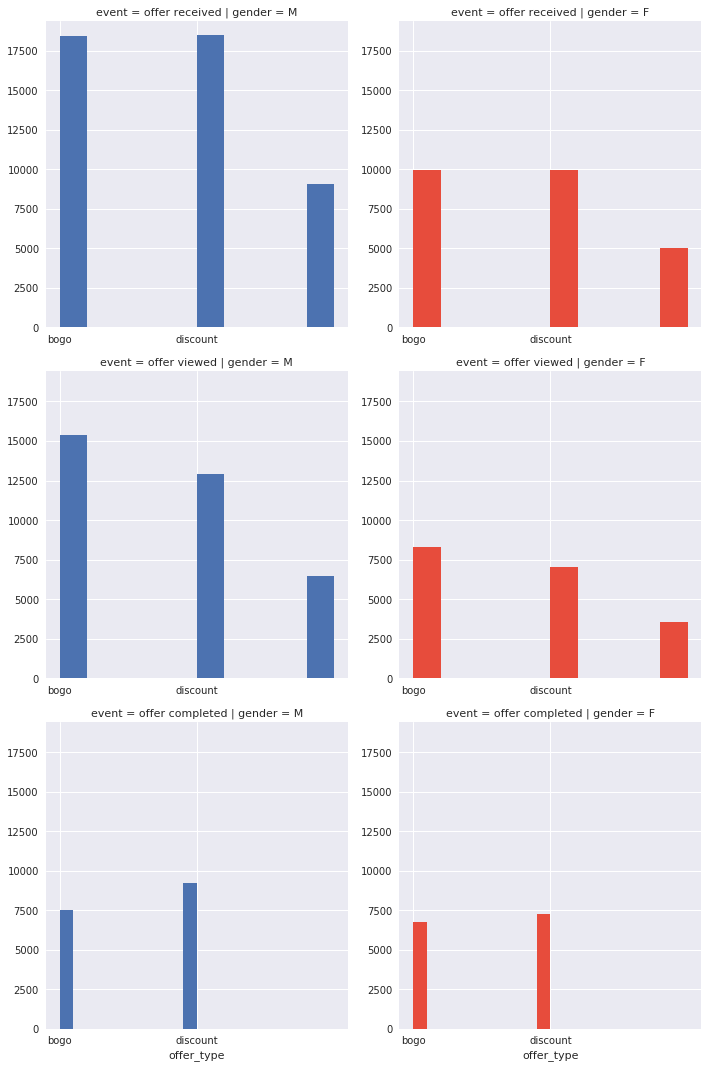

In [87]:
d = {'color': ['C0', "#e74c3c"]}
g = sns.FacetGrid(plot_gender, row='event', col='gender', hue_kws=d, hue='gender', size=5)
g.map(plt.hist, 'offer_type')

Major Analysis from Exploratory Data Analysis
1. The males represent 62.7% of the data and use the Starbucks app more than the females.
2. Specifically, both males & females in the age group 46-60 use app the most.
3. Discount offers are more preferred by the customers. Also, there are less number of customers who actually complete the offer as compared to the ones who just view & ignore it.

#### B) Model Comparisons & evaluation using F1 metric

In [88]:
models = {'Model': ['KNeighborsClassifier (Benchmark)', b_model, c_model], 
          'train F1 score ':[a_train_f1, b_train_f1, c_train_f1], 
          'test F1 score': [a_test_f1 , b_test_f1, c_test_f1] }
          
comp = pd.DataFrame(models)

In [89]:
comp

,Model,train F1 score,test F1 score
0,KNeighborsClassifier (Benchmark),54.346515,32.891019
1,RandomForestClassifier,94.336568,69.304149
2,DecisionTreeClassifier,95.455075,85.098886


We used the test dataset to evaluate the model using F1 metric. We observe that both the model perform better than Benchmark Model(KNeighborsClassifie). The best score is by DecisionTreeClassifier model, as its test F1 score is 85.1 which is much higher than the benchmark. Although RandomForestClassifier scores good compared to benchmark, with a F1 test score 69.30.The F1 scores by DecisionTreeClassifier are good as well as sufficient as our problem to solve is not that sensitive which requires very high F1 score. So our scores are good and can be used for the classification purpose to predict if a customer will respond to an offer or not